# Titanic  - Deep Learning aproach

### obs: this code is from my github(https://github.com/dimitreOliveira/titanicDeepLearning) that's why it's so modular

> ### DEPENDENCIES

In [1]:
import csv
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### DATASET METHODS

In [2]:
def load_data(train_path, test_path):
    """
    method for data loading
    :param train_path: path for the train set file
    :param test_path: path for the test set file
    :return: a 'pandas' array for each set
    """

    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    print("number of training examples = " + str(train_data.shape[0]))
    print("number of test examples = " + str(test_data.shape[0]))
    print("train shape: " + str(train_data.shape))
    print("test shape: " + str(test_data.shape))

    return train_data, test_data


def pre_process_data(df):
    """
    Perform a number of pre process functions on the data set
    :param df: pandas data frame
    :return: updated data frame
    """
    # setting `passengerID` as Index since it wont be necessary for the analysis
    df = df.set_index("PassengerId")

    # convert 'Sex' values
    df['gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # We see that 2 passengers embarked data is missing, we fill those in as the most common Embarked value
    df.loc[df.Embarked.isnull(), 'Embarked'] = df['Embarked'].mode()[0]

    # Replace missing age values with median ages by gender
    for gender in df['gender'].unique():
        median_age = df[(df['gender'] == gender)].Age.median()
        df.loc[(df['Age'].isnull()) & (df['gender'] == gender), 'Age'] = median_age

    # convert 'gender' values to new columns
    df = pd.get_dummies(df, columns=['gender'])

    # convert 'Embarked' values to new columns
    df = pd.get_dummies(df, columns=['Embarked'])

    # bin Fare into five intervals with equal amount of values
#     df['Fare-bin'] = pd.qcut(df['Fare'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

    # bin Age into seven intervals with equal amount of values
    # ('baby','child','teenager','young','mid-age','over-50','senior')
    bins = [0, 4, 12, 18, 30, 50, 65, 100]
    age_index = (1, 2, 3, 4, 5, 6, 7)
    df['Age-bin'] = pd.cut(df['Age'], bins, labels=age_index).astype(int)

    # create a new column 'family' as a sum of 'SibSp' and 'Parch'
    df['family'] = df['SibSp'] + df['Parch'] + 1
    df['family'] = df['family'].map(lambda x: 4 if x > 4 else x)

    # create a new column 'FTicket' as the first character of the 'Ticket'
    df['FTicket'] = df['Ticket'].map(lambda x: x[0])
    # combine smaller categories into one
    df['FTicket'] = df['FTicket'].replace(['W', 'F', 'L', '5', '6', '7', '8', '9'], '4')
    # convert 'FTicket' values to new columns
    df = pd.get_dummies(df, columns=['FTicket'])

    # get titles from the name
    df['title'] = df.apply(lambda row: re.split('[,.]+', row['Name'])[1], axis=1)

    # convert titles to values
    df['title'] = df['title'].map({' Capt': 'Other', ' Master': 'Master', ' Mr': 'Mr', ' Don': 'Other',
                                   ' Dona': 'Other', ' Lady': 'Other', ' Col': 'Other', ' Miss': 'Miss',
                                   ' the Countess': 'Other', ' Dr': 'Other', ' Jonkheer': 'Other', ' Mlle': 'Other',
                                   ' Sir': 'Other', ' Rev': 'Other', ' Ms': 'Other', ' Mme': 'Other', ' Major': 'Other',
                                   ' Mrs': 'Mrs'})
    # convert 'title' values to new columns
    df = pd.get_dummies(df, columns=['title'])

    df = df.drop(['Name', 'Ticket', 'Cabin', 'Sex', 'Fare', 'Age'], axis=1)

    return df


def mini_batches(train_set, train_labels, mini_batch_size):
    """
    Generate mini batches from the data set (data and labels)
    :param train_set: data set with the examples
    :param train_labels: data set with the labels
    :param mini_batch_size: mini batch size
    :return: mini batches
    """
    set_size = train_set.shape[0]
    batches = []
    num_complete_minibatches = set_size // mini_batch_size

    for k in range(0, num_complete_minibatches):
        mini_batch_x = train_set[k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch_y = train_labels[k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if set_size % mini_batch_size != 0:
        mini_batch_x = train_set[(set_size - (set_size % mini_batch_size)):]
        mini_batch_y = train_labels[(set_size - (set_size % mini_batch_size)):]
        mini_batch = (mini_batch_x, mini_batch_y)
        batches.append(mini_batch)

    return batches

### AUXILIARY MODEL METHODS

In [3]:
def create_placeholders(input_size, output_size):
    """
    Creates the placeholders for the tensorflow session.
    :param input_size: scalar, input size
    :param output_size: scalar, output size
    :return: X  placeholder for the data input, of shape [None, input_size] and dtype "float"
    :return: Y placeholder for the input labels, of shape [None, output_size] and dtype "float"
    """

    x = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name="X")
    y = tf.placeholder(shape=(None, output_size), dtype=tf.float32, name="Y")

    return x, y


def forward_propagation(x, parameters, keep_prob=1.0, hidden_activation='relu'):
    """
    Implement forward propagation with dropout for the [LINEAR->RELU]*(L-1)->LINEAR-> computation
    :param x: data, pandas array of shape (input size, number of examples)
    :param parameters: output of initialize_parameters()
    :param keep_prob: probability to keep each node of the layer
    :param hidden_activation: activation function of the hidden layers
    :return: last LINEAR value
    """

    a_dropout = x
    n_layers = len(parameters) // 2  # number of layers in the neural network

    for l in range(1, n_layers):
        a_prev = a_dropout
        a_dropout = linear_activation_forward(a_prev, parameters['w%s' % l], parameters['b%s' % l], hidden_activation)

        if keep_prob < 1.0:
            a_dropout = tf.nn.dropout(a_dropout, keep_prob)

    al = tf.matmul(a_dropout, parameters['w%s' % n_layers]) + parameters['b%s' % n_layers]

    return al


def linear_activation_forward(a_prev, w, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param a_prev: activations from previous layer (or input data): (size of previous layer, number of examples)
    :param w: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    :param b: bias vector, numpy array of shape (size of the current layer, 1)
    :param activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    :return: the output of the activation function, also called the post-activation value
    """

    a = None
    if activation == "sigmoid":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.sigmoid(z)

    elif activation == "relu":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.relu(z)

    elif activation == "leaky relu":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.leaky_relu(z)

    return a


def initialize_parameters(layer_dims):
    """
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :return: python dictionary containing your parameters "w1", "b1", ..., "wn", "bn":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    parameters = {}
    n_layers = len(layer_dims)  # number of layers in the network

    for l in range(1, n_layers):
        parameters['w' + str(l)] = tf.get_variable('w' + str(l), [layer_dims[l - 1], layer_dims[l]],
                                                   initializer=tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layer_dims[l]], initializer=tf.zeros_initializer())

    return parameters


def compute_cost(z3, y):
    """
    :param z3: output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    :param y: "true" labels vector placeholder, same shape as Z3
    :return: Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=z3, labels=y))

    return cost


def predict(data, parameters):
    """
    make a prediction based on a data set and parameters
    :param data: based data set
    :param parameters: based parameters
    :return: array of predictions
    """

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)

        dataset = tf.cast(tf.constant(data), tf.float32)
        fw_prop_result = forward_propagation(dataset, parameters)
        fw_prop_activation = tf.nn.softmax(fw_prop_result)
        prediction = fw_prop_activation.eval()

    return prediction


def accuracy(predictions, labels):
    """
    calculate accuracy between two data sets
    :param predictions: data set of predictions
    :param labels: data set of labels (real values)
    :return: percentage of correct predictions
    """

    prediction_size = predictions.shape[0]
    prediction_accuracy = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / prediction_size

    return 100 * prediction_accuracy


def minibatch_accuracy(predictions, labels):
    """
    calculate accuracy between two data sets
    :param predictions: data set of predictions
    :param labels: data set of labels (real values)
    :return: percentage of correct predictions
    """

    prediction_size = predictions.shape[0]
    prediction_accuracy = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / prediction_size

    return 100 * prediction_accuracy


def l2_regularizer(cost, l2_beta, parameters, n_layers):
    """
    Function to apply l2 regularization to the model
    :param cost: usual cost of the model
    :param l2_beta: beta value used for the normalization
    :param parameters: parameters from the model (used to get weights values)
    :param n_layers: number of layers of the model
    :return: cost updated
    """

    regularizer = 0
    for i in range(1, n_layers):
        regularizer += tf.nn.l2_loss(parameters['w%s' % i])

    cost = tf.reduce_mean(cost + l2_beta * regularizer)

    return cost


def build_submission_name(layers_dims, num_epochs, lr_decay,
                          learning_rate, l2_beta, keep_prob, minibatch_size, num_examples):
    """
    builds a string (submission file name), based on the model parameters
    :param layers_dims: model layers dimensions
    :param num_epochs: model number of epochs
    :param lr_decay: model learning rate decay
    :param learning_rate: model learning rate
    :param l2_beta: beta used on l2 normalization
    :param keep_prob: keep probability used on dropout normalization
    :param minibatch_size: model mini batch size (0 to do not use mini batches)
    :param num_examples: number of model examples (training data)
    :return: built string
    """
    submission_name = 'ly{}-epoch{}.csv' \
        .format(layers_dims, num_epochs)

    if lr_decay != 0:
        submission_name = 'lrdc{}-'.format(lr_decay) + submission_name
    else:
        submission_name = 'lr{}-'.format(learning_rate) + submission_name

    if l2_beta > 0:
        submission_name = 'l2{}-'.format(l2_beta) + submission_name

    if keep_prob < 1:
        submission_name = 'dk{}-'.format(keep_prob) + submission_name

    if minibatch_size != num_examples:
        submission_name = 'mb{}-'.format(minibatch_size) + submission_name

    return submission_name


def plot_model_cost(train_costs, validation_costs, submission_name):
    """
    :param train_costs: array with the costs from the model training
    :param validation_costs: array with the costs from the model validation
    :param submission_name: name of the submission (used for the plot title)
    :return:
    """
    plt.plot(np.squeeze(train_costs), label='Train cost')
    plt.plot(np.squeeze(validation_costs), label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Model: " + submission_name)
    plt.legend()
    plt.show()


def plot_model_accuracy(train_accuracies, validation_accuracies, submission_name):
    """
    :param train_accuracies: array with the accuracies from the model training
    :param validation_accuracies: array with the accuracies from the model validation
    :param submission_name:  name of the submission (used for the plot title)
    :return:
    """
    plt.plot(np.squeeze(train_accuracies), label='Train accuracy')
    plt.plot(np.squeeze(validation_accuracies), label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('iterations (per tens)')
    plt.title("Model: " + submission_name)
    plt.legend()
    plt.show()

### MODEL

In [4]:
def model(train_set, train_labels, validation_set, validation_labels, layers_dims, learning_rate=0.01, num_epochs=1001,
          print_cost=True, plot_cost=True, l2_beta=0., keep_prob=1.0, hidden_activation='relu', return_best=False,
          minibatch_size=0, lr_decay=0, print_accuracy=True, plot_accuracy=True):
    """
    :param train_set: training set
    :param train_labels: training labels
    :param validation_set: validation set
    :param validation_labels: validation labels
    :param layers_dims: array with the layer for the model
    :param learning_rate: learning rate of the optimization
    :param num_epochs: number of epochs of the optimization loop
    :param print_cost: True to print the cost every 500 epochs
    :param plot_cost: True to plot the train and validation cost
    :param l2_beta: beta parameter for the l2 regularization
    :param keep_prob: probability to keep each node of each hidden layer (dropout)
    :param hidden_activation: activation function to be used on the hidden layers
    :param return_best: True to return the highest params from all epochs
    :param minibatch_size: size of th mini batch
    :param lr_decay: if != 0, sets de learning rate decay on each epoch
    :param print_accuracy: True to print the accuracy every 500 epochs
    :param plot_accuracy: True to plot the train and validation accuracy
    :return parameters: parameters learnt by the model. They can then be used to predict.
    :return submission_name: name for the trained model
    """

    ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables

    input_size = layers_dims[0]
    output_size = layers_dims[-1]
    num_examples = train_set.shape[0]
    n_layers = len(layers_dims)
    train_costs = []
    validation_costs = []
    train_accuracies = []
    validation_accuracies = []
    prediction = []
    best_iteration = [float('inf'), 0, float('-inf'), 0]
    best_params = None

    if minibatch_size == 0 or minibatch_size > num_examples:
        minibatch_size = num_examples

    num_minibatches = num_examples // minibatch_size

    if num_minibatches == 0:
        num_minibatches = 1

    submission_name = build_submission_name(layers_dims, num_epochs, lr_decay, learning_rate, l2_beta, keep_prob,
                                            minibatch_size, num_examples)

    x, y = create_placeholders(input_size, output_size)
    tf_valid_dataset = tf.cast(tf.constant(validation_set), tf.float32)
    parameters = initialize_parameters(layers_dims)

    fw_output = forward_propagation(x, parameters, keep_prob, hidden_activation)
    train_cost = compute_cost(fw_output, y)
    train_prediction = tf.nn.softmax(fw_output)

    fw_output_valid = forward_propagation(tf_valid_dataset, parameters, 1, hidden_activation)
    validation_cost = compute_cost(fw_output_valid, validation_labels)
    valid_prediction = tf.nn.softmax(fw_output_valid)

    if l2_beta > 0:
        train_cost = l2_regularizer(train_cost, l2_beta, parameters, n_layers)
        validation_cost = l2_regularizer(validation_cost, l2_beta, parameters, n_layers)

    if lr_decay != 0:
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.inverse_time_decay(learning_rate, global_step=global_step, decay_rate=lr_decay,
                                                    decay_steps=1)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_cost, global_step=global_step)
    else:
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(num_epochs):
            train_epoch_cost = 0.
            validation_epoch_cost = 0.

            minibatches = mini_batches(train_set, train_labels, minibatch_size)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                feed_dict = {x: minibatch_X, y: minibatch_Y}

                _, minibatch_train_cost, prediction, minibatch_validation_cost = sess.run(
                    [optimizer, train_cost, train_prediction, validation_cost], feed_dict=feed_dict)

                train_epoch_cost += minibatch_train_cost / num_minibatches
                validation_epoch_cost += minibatch_validation_cost / num_minibatches

            validation_accuracy = accuracy(valid_prediction.eval(), validation_labels)
            train_accuracy = accuracy(prediction, minibatch_Y)

            if print_cost is True and epoch % 500 == 0:
                print("Train cost after epoch %i: %f" % (epoch, train_epoch_cost))
                print("Validation cost after epoch %i: %f" % (epoch, validation_epoch_cost))

            if print_accuracy is True and epoch % 500 == 0:
                print('Train accuracy after epoch {}: {:.2f}'.format(epoch, train_accuracy))
                print('Validation accuracy after epoch {}: {:.2f}'.format(epoch, validation_accuracy))

            if plot_cost is True and epoch % 10 == 0:
                train_costs.append(train_epoch_cost)
                validation_costs.append(validation_epoch_cost)

            if plot_accuracy is True and epoch % 10 == 0:
                train_accuracies.append(train_accuracy)
                validation_accuracies.append(validation_accuracy)

            if return_best is True:
                if validation_epoch_cost < best_iteration[0]:
                    best_iteration[0] = validation_epoch_cost
                    best_iteration[1] = epoch
                    best_params = sess.run(parameters)
                if validation_accuracy > best_iteration[2]:
                    best_iteration[2] = validation_accuracy
                    best_iteration[3] = epoch
                    best_params = sess.run(parameters)

        if return_best is True:
            parameters = best_params
        else:
            parameters = sess.run(parameters)

        print("Parameters have been trained, getting metrics...")

        train_accuracy = accuracy(predict(train_set, parameters), train_labels)
        validation_accuracy = accuracy(predict(validation_set, parameters), validation_labels)

        print('Train accuracy: {:.2f}'.format(train_accuracy))
        print('Validation accuracy: {:.2f}'.format(validation_accuracy))
        print('Lowest validation cost: {:.2f} at epoch {}'.format(best_iteration[0], best_iteration[1]))
        print('Highest validation accuracy: {:.2f} at epoch {}'.format(best_iteration[2], best_iteration[3]))

        submission_name = 'tr_acc-{:.2f}-vd_acc{:.2f}-'.format(train_accuracy, validation_accuracy) + submission_name

        if return_best is True:
            print('Lowest cost: {:.2f} at epoch {}'.format(best_iteration[0], best_iteration[1]))

        if plot_cost is True:
            plot_model_cost(train_costs, validation_costs, submission_name)

        if plot_accuracy is True:
            plot_model_accuracy(train_accuracies, validation_accuracies, submission_name)

        return parameters, submission_name

### Load data

In [5]:
TRAIN_PATH = '../input/train.csv'
TEST_PATH = '../input/test.csv'

train, test = load_data(TRAIN_PATH, TEST_PATH)

CLASSES = 2
train_dataset_size = train.shape[0]
# The labels need to be one-hot encoded
train_raw_labels = pd.get_dummies(train.Survived).as_matrix()

number of training examples = 891
number of test examples = 418
train shape: (891, 12)
test shape: (418, 11)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


### Pre process data

In [6]:
train = pre_process_data(train)
test = pre_process_data(test)

# drop unwanted columns
train_pre = train.drop(['Survived'], axis=1).as_matrix().astype(np.float)
test_pre = test.as_matrix().astype(np.float)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Normalize data

In [7]:
# scale values
standard_scaler = preprocessing.StandardScaler()
train_pre = standard_scaler.fit_transform(train_pre)
test_pre = standard_scaler.fit_transform(test_pre)

# data split
X_train, X_valid, Y_train, Y_valid = train_test_split(train_pre, train_raw_labels, test_size=0.3, random_state=1)

### Model parameters

In [8]:
# hyperparameters
input_layer = train_pre.shape[1]
output_layer = 2
num_epochs = 10001
learning_rate = 0.0001
train_size = 0.8
# layers_dims = [input_layer, 256, 128, 64, output_layer]
layers_dims = [input_layer, 512, 128, 64, output_layer]

### Train model

Parameters have been trained, getting metrics...
Train accuracy: 85.23
Validation accuracy: 79.48
Lowest validation cost: 0.63 at epoch 9884
Highest validation accuracy: 79.85 at epoch 536
Lowest cost: 0.63 at epoch 9884


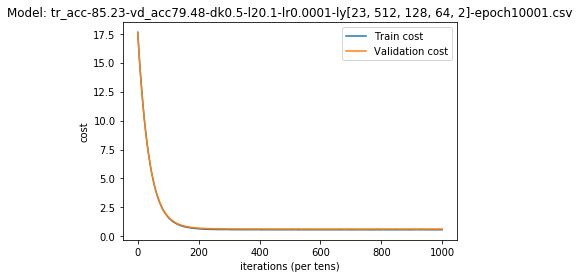

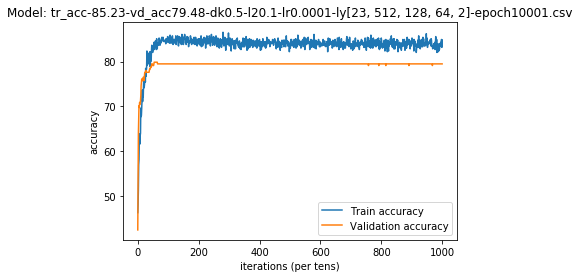

In [9]:
parameters, submission_name = model(X_train, Y_train, X_valid, Y_valid, layers_dims, num_epochs=num_epochs,
                                    learning_rate=learning_rate, print_cost=False, plot_cost=True, l2_beta=0.1,
                                    keep_prob=0.5, minibatch_size=0, return_best=True, print_accuracy=False,
                                    plot_accuracy=True)

### Make predictions

In [10]:
final_prediction = predict(test_pre, parameters)

In [11]:
submission = pd.DataFrame({"PassengerId":test.index.values})
submission["Survived"] = np.argmax(final_prediction, 1)
submission.to_csv("submission.csv", index=False)